In [2]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

from transformers import *

import collections
import os

import nltk
%matplotlib inline

from pandas import Series,DataFrame
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# 先处理 DiffVec的数据
filename = 'diffvec_word_pairs_final.SEMBLESS.csv'
file_colname=['relation','word1','word2']
df = pd.read_csv(filename,header=None,names=file_colname)

df

,relation,word1,word2
0,ATTRIBUTE$Action:ObjectAttribute,apple,picker
1,ATTRIBUTE$Action:ObjectAttribute,collect,fee
2,ATTRIBUTE$Action:ObjectAttribute,hunter,game
3,ATTRIBUTE$Action:ObjectAttribute,paint,house
4,ATTRIBUTE$Action:ObjectAttribute,vitamin,deficiency
...,...,...,...
12453,vn-deriv,yawn,yawning
12454,vn-deriv,yearn,yearning
12455,vn-deriv,yell,yelling
12456,vn-deriv,yield,yielding


In [35]:
df_clean = df[df['relation'].str.contains('Prevention')]
df_clean

,relation,word1,word2
287,CAUSE-PURPOSE$Prevention,acetaminophen,headache
288,CAUSE-PURPOSE$Prevention,acid,base
289,CAUSE-PURPOSE$Prevention,activity,boredom
290,CAUSE-PURPOSE$Prevention,antibiotic,infection
291,CAUSE-PURPOSE$Prevention,antibiotics,bacteria
292,CAUSE-PURPOSE$Prevention,cat,mouse
293,CAUSE-PURPOSE$Prevention,cure,disease
294,CAUSE-PURPOSE$Prevention,education,ignorance
295,CAUSE-PURPOSE$Prevention,fast,slow
296,CAUSE-PURPOSE$Prevention,food,hunger


In [153]:
# 先处理相同 word1 的数据，合并，再转换成列表
data = df_clean.groupby(['word1'])['word2'].apply(list).to_dict()
print(data)


# 提取形容词
adj_data_dict = {}
not_adj = {}

for (key,value) in data.items():
    if nltk.pos_tag([key])[0][1] == "JJ":
        adj_data_dict[key] = value
    else:
        not_adj[key] = nltk.pos_tag([key])[0][1]
        
print(adj_data_dict)
print('============================================')
print(not_adj)

# 最终的数据是 adj_data_dict


{'acetaminophen': ['headache'], 'acid': ['base'], 'activity': ['boredom'], 'antibiotic': ['infection'], 'antibiotics': ['bacteria'], 'cat': ['mouse'], 'cure': ['disease'], 'education': ['ignorance'], 'fast': ['slow'], 'food': ['hunger'], 'fungicide': ['fungus', 'mold'], 'good': ['bad'], 'happy': ['sad'], 'immunization': ['disease'], 'insecticide': ['bugs', 'pests'], 'knowledge': ['ignorance'], 'locks': ['theft'], 'mediation': ['conflict'], 'medicine': ['disease', 'illness'], 'money': ['poverty'], 'nice': ['evil'], 'preparation': ['disaster'], 'rest': ['exhaustion'], 'shot': ['disease'], 'sleep': ['exhaustion', 'tiredness'], 'sun': ['darkness'], 'swimming': ['drowning'], 'vaccine': ['virus'], 'water': ['thirst']}
{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['sad'], 'nice': ['evil']}
{'acetaminophen': 'NN', 'acid': 'NN', 'activity': 'NN', 'antibiotics': 'NNS', 'cat': 'NN', 'cure': 'NN', 'education': 'NN', 'fast': 'NN', 'food': 'NN', 'fungicide': 'NN', 'immunization': 'NN', 'i

In [40]:
# 再处理 BAT3的数据

In [43]:
bat3file1 = open('antonyms_adj.txt')
bat3file2 = open('antonyms_comparable.txt')


antonyms_adj = bat3file1.read()
antonyms_comparable = bat3file2.read()

print(antonyms_adj)
print(antonyms_comparable)

beautiful/pretty	ugly/disfigured/evil-looking/fugly/grotesque/monstrous/hideous/repulsive/ill-favored/ill-favoured/scrofulous/unlovely/unpicturesque/unsightly/displeasing/unattractive/awkward
big	small/atomic/subatomic/bantam/diminutive/lilliputian/midget/petite/tiny/flyspeck/bitty/bittie/teensy/teentsy/teeny/wee/weeny/weensy/teensy-weensy/teeny-weeny/itty-bitty/itsy-bitsy/dinky/dwarfish/elfin/elflike/gnomish/half-size/infinitesimal/minute/lesser/microscopic/microscopical/micro/miniature/minuscule/miniscule/olive-sized/pocket-size/pocket-sized/pocketable/puny/runty/shrimpy/slender/slim/smaller/littler/smallish/small-scale/undersize/undersized
bright	pale/colorless/colourless/dull/neutral/pale/white/bleached/faded/washed-out/washy/drab/somber/sombre/dulled/greyed/etiolate/etiolated/lurid/waxen/waxlike/waxy/whitened
cheap	expensive/big-ticket/high-ticket/costly/dear/high-priced/pricey/pricy/dearly-won/overpriced/valuable
clean	dirty/soiled/unclean/augean/bedraggled/draggled/befouled/foul

In [69]:
antonyms_dict = {}
files = [bat3file1,bat3file2]

for each in files:
    
    # put the pos to the start of file
    each.seek(0, os.SEEK_SET)

    for line in each.read().split("\n"):
        # 处理 空行
        if not line:
            continue
        line_split = line.split()
        master = line_split[0]
        slave = line_split[1].split('/')
        
        # 处理多个 master
        if '/' in master:
            master_list = master.split('/')
            for each_master in master_list:
                if not each_master in antonyms_dict:
                    antonyms_dict[each_master] = slave
        else:
            if not master in antonyms_dict:
                antonyms_dict[master] = slave
            
ordered_antonyms_dict = collections.OrderedDict(sorted(antonyms_dict.items()))
ordered_antonyms_dict

#print(type(ordered_antonyms_dict))

# 最终的数据是 ordered_antonyms_dict

OrderedDict([('able', ['unable', 'incapable', 'incompetent', 'unequal']),
             ('abundant',
              ['scarce',
               'rare',
               'tight',
               'meager',
               'meagre',
               'meagerly',
               'stingy',
               'scrimpy',
               'insufficient',
               'deficient']),
             ('aware',
              ['unaware',
               'oblivious',
               'unmindful',
               'unconscious',
               'unsuspecting',
               'asleep',
               'insensible',
               'unconscious',
               'unwitting',
               'ignorant',
               'indifferent',
               'oblivious']),
             ('beautiful',
              ['ugly',
               'disfigured',
               'evil-looking',
               'fugly',
               'grotesque',
               'monstrous',
               'hideous',
               'repulsive',
               'ill-favored',


In [54]:
# 全是形容词，不需要使用nltk选出形容词
# 但是有的 master 是有两个的需要处理一下

In [62]:
models = {}

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model, tokenizer, mask_token = models['roberta-large']

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
templates = [
    'John is * but Mary is  _ .'
]

In [64]:
# 处理 am-for-bert 数据

In [151]:
import re
am_for_bert = 'am_for_bert_antonyms.txt'
#am_for_bert_file = open(am_for_bert)

with open(am_for_bert, 'r') as f:
    file_lines = f.readlines()

keymap =  [re.split(' |\t',string) for string in file_lines]

adj_antonym = {}
flag = 0
for item in keymap:

    # 筛选出形态词的反义词
    if (('antonym' == item[4]) and ('a' in item[3])):
        master3 = item[2]
        slave3 = []
        length = len(item)
        
        for i in range(int((length-5)/2)):
            slave3.append(item[5+i*2])
        
        adj_antonym[master3] = slave3
        
print(adj_antonym)
print(len(adj_antonym))

# 最终的数据 adj_antonym


{'new': ['old'], 'other': ['same'], 'many': ['few'], 'high': ['low'], 'same': ['other'], 'general': ['specific'], 'international': ['national'], 'local': ['national'], 'small': ['big', 'large'], 'large': ['little', 'small'], 'much': ['little'], 'old': ['young'], 'single': ['common'], 'different': ['same'], 'white': ['black'], 'few': ['many'], 'popular': ['unpopular'], 'black': ['white'], 'young': ['old'], 'northern': ['southern'], 'married': ['unmarried'], 'southern': ['northern'], 'little': ['big', 'large'], 'good': ['bad'], 'available': ['unavailable'], 'full': ['empty'], 'able': ['unable'], 'successful': ['unsuccessful'], 'native': ['foreign'], 'possible': ['impossible'], 'natural': ['unnatural'], 'big': ['little', 'small'], 'strong': ['weak'], 'active': ['inactive'], 'limited': ['unlimited'], 'low': ['high'], 'foreign': ['domestic'], 'related': ['unrelated'], 'legal': ['illegal'], 'true': ['false'], 'dead': ['alive'], 'specific': ['general'], 'hard': ['easy'], 'likely': ['unlikely'

In [157]:
print(adj_data_dict)
print('===========================')
print(ordered_antonyms_dict)
print('===========================')
print(adj_antonym)


{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['sad'], 'nice': ['evil']}
OrderedDict([('able', ['unable', 'incapable', 'incompetent', 'unequal']), ('abundant', ['scarce', 'rare', 'tight', 'meager', 'meagre', 'meagerly', 'stingy', 'scrimpy', 'insufficient', 'deficient']), ('aware', ['unaware', 'oblivious', 'unmindful', 'unconscious', 'unsuspecting', 'asleep', 'insensible', 'unconscious', 'unwitting', 'ignorant', 'indifferent', 'oblivious']), ('beautiful', ['ugly', 'disfigured', 'evil-looking', 'fugly', 'grotesque', 'monstrous', 'hideous', 'repulsive', 'ill-favored', 'ill-favoured', 'scrofulous', 'unlovely', 'unpicturesque', 'unsightly', 'displeasing', 'unattractive', 'awkward']), ('big', ['small', 'atomic', 'subatomic', 'bantam', 'diminutive', 'lilliputian', 'midget', 'petite', 'tiny', 'flyspeck', 'bitty', 'bittie', 'teensy', 'teentsy', 'teeny', 'wee', 'weeny', 'weensy', 'teensy-weensy', 'teeny-weeny', 'itty-bitty', 'itsy-bitsy', 'dinky', 'dwarfish', 'elfin', 'elflike', 'gnomi

In [158]:
final_antonym_dict = {}
final_antonym_dict.update(adj_data_dict)
final_antonym_dict.update(ordered_antonyms_dict)
final_antonym_dict.update(adj_antonym)

In [174]:
# 合并后的数据
print(final_antonym_dict)
print('===========')

# 复制一份作为 最后结果的json 文件的生成文件
import copy

import json

{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['unhappy'], 'nice': ['nasty'], 'able': ['unable'], 'abundant': ['scarce', 'rare', 'tight', 'meager', 'meagre', 'meagerly', 'stingy', 'scrimpy', 'insufficient', 'deficient'], 'aware': ['unaware', 'oblivious', 'unmindful', 'unconscious', 'unsuspecting', 'asleep', 'insensible', 'unconscious', 'unwitting', 'ignorant', 'indifferent', 'oblivious'], 'beautiful': ['ugly', 'disfigured', 'evil-looking', 'fugly', 'grotesque', 'monstrous', 'hideous', 'repulsive', 'ill-favored', 'ill-favoured', 'scrofulous', 'unlovely', 'unpicturesque', 'unsightly', 'displeasing', 'unattractive', 'awkward'], 'big': ['little', 'small'], 'bright': ['pale', 'colorless', 'colourless', 'dull', 'neutral', 'pale', 'white', 'bleached', 'faded', 'washed-out', 'washy', 'drab', 'somber', 'sombre', 'dulled', 'greyed', 'etiolate', 'etiolated', 'lurid', 'waxen', 'waxlike', 'waxy', 'whitened'], 'cheap': ['expensive', 'big-ticket', 'high-ticket', 'costly', 'dear', 'high-pric

In [161]:
templates = [
    'John is * but Mary is _ .',
    'The antonym of * is _ .'
]

John is antibiotic but Mary is _ .
['not', 'Catholic', 'Jewish', 'pregnant', 'alive', 'gay', 'Christian', 'dead', 'Baptist', 'Muslim']
tensor([0.2017, 0.0369, 0.0303, 0.0162, 0.0140, 0.0109, 0.0100, 0.0094, 0.0087,
        0.0072])
{'infection': tensor(8.2644e-07)}
max_probe is: tensor(8.2644e-07)
20
40
80
160
320
640
1280
2560
5120
10240
20480
the position of max probe is: 12846
-----------------------------------------------------
*****************************************************
John is good but Mary is _ .
['better', 'bad', 'good', 'great', 'beautiful', 'evil', 'worse', 'perfect', 'wonderful', 'amazing']
tensor([0.4136, 0.0610, 0.0500, 0.0352, 0.0322, 0.0296, 0.0150, 0.0137, 0.0118,
        0.0099])
{'bad': tensor(0.0610)}
max_probe is: tensor(0.0610)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is happy but Mary is _ .
['sad', 'not', 'worried', 'unhappy', 'afraid', 'angry', 'sca

['not', 'stronger', 'closer', 'ahead', 'better', 'far', 'free', 'gone', 'alone', 'different']
tensor([0.0623, 0.0469, 0.0453, 0.0271, 0.0267, 0.0206, 0.0146, 0.0133, 0.0130,
        0.0120])
farawayis not in list
{'distant': tensor(0.0074), 'remote': tensor(0.0004), 'removed': tensor(0.0002), 'far': tensor(0.0206), '': tensor(8.0063e-05)}
max_probe is: tensor(0.0206)
the position of max probe is: 5
-----------------------------------------------------
*****************************************************
John is colorful but Mary is _ .
['beautiful', 'not', 'white', 'plain', 'black', 'simple', 'real', 'pure', 'quiet', 'elegant']
tensor([0.1292, 0.0326, 0.0304, 0.0263, 0.0257, 0.0248, 0.0193, 0.0190, 0.0178,
        0.0170])
colorlessis not in list
colourlessis not in list
bleachedis not in list
washed-outis not in list
washyis not in list
drabis not in list
somberis not in list
sombreis not in list
dulledis not in list
greyedis not in list
etiolateis not in list
etiolatedis not in list

['solid', 'liquid', 'not', 'fluid', 'water', 'inert', 'transparent', 'pure', 'immortal', 'dry']
tensor([0.5519, 0.1244, 0.0578, 0.0150, 0.0124, 0.0091, 0.0090, 0.0064, 0.0062,
        0.0050])
coagulatedis not in list
solidifiedis not in list
congealedis not in list
jelledis not in list
jelliedis not in list
semisolidis not in list
solid-stateis not in list
{'solid': tensor(0.5519), 'hard': tensor(0.0005), 'concrete': tensor(0.0007), 'dry': tensor(0.0050)}
max_probe is: tensor(0.5519)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is generous but Mary is _ .
['not', 'selfish', 'kind', 'generous', 'greedy', 'modest', 'wise', 'afraid', 'poor', 'practical']
tensor([0.0930, 0.0457, 0.0277, 0.0224, 0.0222, 0.0167, 0.0136, 0.0135, 0.0128,
        0.0120])
stingyis not in list
beggarlyis not in list
chinchyis not in list
chintzyis not in list
cheeseparingis not in list
penny-pinchingis not in lis

['dark', 'not', 'white', 'beautiful', 'black', 'pale', 'darker', 'red', 'fair', 'blonde']
tensor([0.1195, 0.1150, 0.0908, 0.0759, 0.0593, 0.0540, 0.0440, 0.0253, 0.0243,
        0.0181])
tannedis not in list
bronzedis not in list
suntannedis not in list
brunetis not in list
brunetteis not in list
{}
John is pretty but Mary is _ .
['beautiful', 'pretty', 'better', 'smarter', 'special', 'sexy', 'real', 'more', 'lovely', 'amazing']
tensor([0.2285, 0.1289, 0.0347, 0.0189, 0.0165, 0.0161, 0.0161, 0.0159, 0.0126,
        0.0122])
disfiguredis not in list
evil-lookingis not in list
fuglyis not in list
repulsiveis not in list
ill-favoredis not in list
ill-favouredis not in list
scrofulousis not in list
unlovelyis not in list
unpicturesqueis not in list
unsightlyis not in list
displeasingis not in list
unattractiveis not in list
{'ugly': tensor(0.0072), 'grotesque': tensor(1.7344e-05), 'monstrous': tensor(2.5896e-05), 'hideous': tensor(0.0002), 'awkward': tensor(4.9993e-05)}
max_probe is: tenso

['loose', 'free', 'not', 'open', 'soft', 'flexible', 'tight', 'strong', 'thin', 'relaxed']
tensor([0.2238, 0.0875, 0.0487, 0.0319, 0.0269, 0.0219, 0.0200, 0.0179, 0.0137,
        0.0106])
baggyis not in list
loose-fittingis not in list
flyawayis not in list
{'loose': tensor(0.2238), 'lax': tensor(0.0054), 'sloppy': tensor(0.0005), 'free': tensor(0.0875), 'liberal': tensor(0.0004), 'informal': tensor(1.3132e-05), 'unofficial': tensor(3.1635e-06)}
max_probe is: tensor(0.2238)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is warm but Mary is _ .
['cold', 'not', 'freezing', 'frozen', 'warm', 'chilly', 'colder', 'hot', 'hungry', 'afraid']
tensor([0.7989, 0.0324, 0.0157, 0.0117, 0.0103, 0.0103, 0.0072, 0.0066, 0.0065,
        0.0045])
frostyis not in list
frigidis not in list
{'cool': tensor(0.0040), 'cold': tensor(0.7989), 'chilly': tensor(0.0103)}
max_probe is: tensor(0.7989)
the position of 

['young', 'new', 'younger', 'beautiful', 'old', 'not', 'wise', 'pretty', 'pregnant', 'born']
tensor([0.7566, 0.0291, 0.0228, 0.0164, 0.0133, 0.0076, 0.0047, 0.0047, 0.0038,
        0.0038])
{'young': tensor(0.7566)}
max_probe is: tensor(0.7566)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is single but Mary is _ .
['married', 'engaged', 'pregnant', 'not', 'divorced', 'dating', 'single', 'unmarried', 'attached', 'involved']
tensor([0.5571, 0.1394, 0.1222, 0.0722, 0.0275, 0.0059, 0.0052, 0.0038, 0.0030,
        0.0025])
{'common': tensor(3.6739e-06)}
max_probe is: tensor(3.6739e-06)
20
40
80
160
320
640
1280
the position of max probe is: 1195
-----------------------------------------------------
*****************************************************
John is different but Mary is _ .
['not', 'different', 'better', 'special', 'Jesus', 'unique', 'Mary', 'same', 'beautiful', 'more']
tensor([0.1

['home', 'not', 'local', 'native', 'domestic', 'divine', 'American', 'English', 'here', 'Greek']
tensor([0.1633, 0.1237, 0.0653, 0.0393, 0.0288, 0.0246, 0.0236, 0.0170, 0.0168,
        0.0124])
{'domestic': tensor(0.0288)}
max_probe is: tensor(0.0288)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
John is related but Mary is _ .
['not', 'unrelated', 'different', 'older', 'married', 'related', 'sister', 'younger', 'distant', 't']
tensor([0.6874, 0.0721, 0.0181, 0.0099, 0.0096, 0.0094, 0.0086, 0.0084, 0.0063,
        0.0049])
{'unrelated': tensor(0.0721)}
max_probe is: tensor(0.0721)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is legal but Mary is _ .
['not', 'illegal', 'legal', 'illegitimate', 'dead', 'immoral', 't', 'alive', 'Catholic', 'Jewish']
tensor([0.6468, 0.0965, 0.0184, 0.0166, 0.0152, 0

['not', 'divine', 'spiritual', 'religious', 'missionary', 'Catholic', 'heavenly', 'independent', 'foreign', 'holy']
tensor([0.2800, 0.1086, 0.0416, 0.0263, 0.0243, 0.0151, 0.0146, 0.0140, 0.0134,
        0.0108])
{'foreign': tensor(0.0134)}
max_probe is: tensor(0.0134)
the position of max probe is: 8
-----------------------------------------------------
*****************************************************
John is formal but Mary is _ .
['not', 'informal', 'personal', 'spiritual', 'passionate', 'real', 'intuitive', 'spontaneous', 'emotional', 'humble']
tensor([0.1038, 0.0633, 0.0297, 0.0270, 0.0252, 0.0203, 0.0165, 0.0160, 0.0157,
        0.0147])
{'informal': tensor(0.0633)}
max_probe is: tensor(0.0633)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is external but Mary is _ .
['internal', 'interior', 'inner', 'external', 'spiritual', 'inside', 'inward', 'within', 'Internal', 'not']
tenso

['strong', 'tough', 'firm', 'hard', 'fierce', 'stern', 'cold', 'stubborn', 'stronger', 'powerful']
tensor([0.4540, 0.1001, 0.0820, 0.0678, 0.0484, 0.0152, 0.0097, 0.0091, 0.0085,
        0.0069])
{'hard': tensor(0.0678)}
max_probe is: tensor(0.0678)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
John is stable but Mary is _ .
['not', 'unstable', 'pregnant', 'troubled', 'volatile', 'unpredictable', 'restless', 'unhappy', 'struggling', 'dangerous']
tensor([0.3624, 0.1557, 0.0262, 0.0191, 0.0118, 0.0106, 0.0093, 0.0089, 0.0064,
        0.0058])
{'unstable': tensor(0.1557)}
max_probe is: tensor(0.1557)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is usual but Mary is _ .
['not', 'unusual', 'rare', 'special', 'different', 'unique', 'uncommon', 'new', 'a', '']
tensor([0.1347, 0.1197, 0.0698, 0.0650, 0.

['unreliable', 'not', 'unpredictable', 'trustworthy', 'unstable', 'reliable', 'inconsistent', 'dangerous', 'deceptive', 'different']
tensor([0.3129, 0.1677, 0.0292, 0.0221, 0.0114, 0.0110, 0.0104, 0.0092, 0.0069,
        0.0054])
{'unreliable': tensor(0.3129)}
max_probe is: tensor(0.3129)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is sudden but Mary is _ .
['not', 'ready', 'patient', 'late', 'waiting', 'silent', 'prepared', 'strong', 'quiet', 'pregnant']
tensor([0.2132, 0.0356, 0.0256, 0.0214, 0.0197, 0.0120, 0.0119, 0.0105, 0.0101,
        0.0083])
{'gradual': tensor(0.0003)}
max_probe is: tensor(0.0003)
20
40
80
160
320
640
the position of max probe is: 446
-----------------------------------------------------
*****************************************************
John is unlikely but Mary is _ .
['possible', 'not', 'likely', 'certain', 'probable', 'unlikely', 'impossible', 'definitel

['amazing', 'better', 'incredible', 'beautiful', 'more', 'awesome', 'unbelievable', 'wonderful', 'extraordinary', 'too']
tensor([0.1876, 0.0958, 0.0666, 0.0323, 0.0301, 0.0190, 0.0185, 0.0163, 0.0136,
        0.0131])
{'credible': tensor(2.9341e-05)}
max_probe is: tensor(2.9341e-05)
20
40
80
160
320
640
1280
the position of max probe is: 1188
-----------------------------------------------------
*****************************************************
John is unstable but Mary is _ .
['not', 'stable', 'strong', 'beautiful', 'sane', 'unstable', 'calm', 'resilient', 'perfect', 'loyal']
tensor([0.1899, 0.1115, 0.0492, 0.0175, 0.0163, 0.0150, 0.0144, 0.0114, 0.0103,
        0.0097])
{'stable': tensor(0.1115)}
max_probe is: tensor(0.1115)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is unhappy but Mary is _ .
['happy', 'not', 'hopeful', 'happier', 'pleased', 'content', 'unhappy', 'worried', 'ecs

['married', 'pregnant', 'not', 'engaged', 'unmarried', 'divorced', 'single', 'Catholic', '', 'sterile']
tensor([0.3514, 0.3246, 0.1566, 0.0515, 0.0099, 0.0096, 0.0060, 0.0058, 0.0051,
        0.0026])
{'married': tensor(0.3514)}
max_probe is: tensor(0.3514)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is idle but Mary is _ .
['busy', 'not', 'awake', 'active', 'working', 'asleep', 'restless', 'sleeping', 'ready', 'praying']
tensor([0.2299, 0.0759, 0.0405, 0.0320, 0.0267, 0.0246, 0.0234, 0.0233, 0.0161,
        0.0130])
{'busy': tensor(0.2299)}
max_probe is: tensor(0.2299)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is bisexual but Mary is _ .
['not', 'gay', 'married', 'lesbian', 'heterosexual', 'homosexual', 'straight', 'single', 'Jewish', 'transgender']
tensor([0.5020, 0.1214, 0.0635, 0.0

['wise', 'strong', 'smart', 'not', 'cunning', 'clever', 'intelligent', 'wiser', 'brave', 'beautiful']
tensor([0.1334, 0.0477, 0.0465, 0.0438, 0.0322, 0.0257, 0.0251, 0.0207, 0.0169,
        0.0157])
{'sophisticated': tensor(0.0037)}
max_probe is: tensor(0.0037)
20
40
the position of max probe is: 37
-----------------------------------------------------
*****************************************************
John is affirmative but Mary is _ .
['negative', 'silent', 'passive', 'affirmative', 'not', 'neutral', 'defensive', 'positive', 'ambiguous', 'undecided']
tensor([0.4274, 0.1127, 0.0488, 0.0384, 0.0335, 0.0248, 0.0217, 0.0161, 0.0126,
        0.0094])
{'negative': tensor(0.4274)}
max_probe is: tensor(0.4274)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is impractical but Mary is _ .
['not', 'practical', 'beautiful', 'divine', 'perfect', 'right', 'real', 'pragmatic', 'true', 'impractical'

['realistic', 'not', 'real', 'beautiful', 'unrealistic', 'sincere', 'perfect', 'practical', 'right', 'true']
tensor([0.1635, 0.1139, 0.1119, 0.0298, 0.0191, 0.0176, 0.0171, 0.0162, 0.0145,
        0.0143])
{'realistic': tensor(0.1635)}
max_probe is: tensor(0.1635)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is improbable but Mary is _ .
['not', 'impossible', 'certain', 'unlikely', 'possible', 'sure', 'real', 'likely', 'inevitable', 'indispensable']
tensor([0.2160, 0.0557, 0.0489, 0.0340, 0.0235, 0.0205, 0.0182, 0.0166, 0.0166,
        0.0164])
{'probable': tensor(0.0152)}
max_probe is: tensor(0.0152)
20
the position of max probe is: 10
-----------------------------------------------------
*****************************************************
John is impartial but Mary is _ .
['not', 'biased', 'conflicted', 'Catholic', 'involved', 'impartial', 'corrupt', 'religious', 'evil', 'loyal']
ten

['not', '', 'productive', '.', 'pregnant', 'beautiful', 'fertile', 'successful', 'brilliant', 'wonderful']
tensor([0.1836, 0.0602, 0.0373, 0.0288, 0.0270, 0.0247, 0.0203, 0.0134, 0.0116,
        0.0083])
{'productive': tensor(0.0373)}
max_probe is: tensor(0.0373)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
John is discontinuous but Mary is _ .
['not', 'continuous', 'discrete', '', 'canonical', 'consistent', 'complete', 'transitional', 'explicit', 'persistent']
tensor([0.5876, 0.1210, 0.0106, 0.0102, 0.0089, 0.0085, 0.0059, 0.0057, 0.0050,
        0.0033])
{'continuous': tensor(0.1210)}
max_probe is: tensor(0.1210)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is dependable but Mary is _ .
['not', 'unreliable', 'unpredictable', 'unstable', 'vulnerable', 'stubborn', 'loyal', 'trustworthy', 'dange

['not', 'logical', 'rational', 'divine', 'irrational', 'beautiful', 'right', 'pragmatic', 'brilliant', 'sensible']
tensor([0.1584, 0.1346, 0.0434, 0.0387, 0.0288, 0.0207, 0.0155, 0.0149, 0.0141,
        0.0134])
{'logical': tensor(0.1346)}
max_probe is: tensor(0.1346)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is uninjured but Mary is _ .
['', 'killed', 'injured', 'not', '.', 'wounded', 'shot', 'hurt', 'attacked', 'hospitalized']
tensor([0.1980, 0.0877, 0.0561, 0.0510, 0.0300, 0.0256, 0.0248, 0.0229, 0.0215,
        0.0176])
{'injured': tensor(0.0561)}
max_probe is: tensor(0.0561)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
John is inedible but Mary is _ .
['not', 'delicious', '', 'edible', 'tasty', 'vegetarian', '.', 'divine', 'beautiful', 'alive']
tensor([0.3335, 0.1142, 0.0456, 0.0448, 0.

['not', 'commercial', '', 'religious', 'Catholic', 'Christian', '.', 'evangelical', 'advertising', 'a']
tensor([0.3535, 0.1938, 0.0638, 0.0276, 0.0261, 0.0145, 0.0128, 0.0084, 0.0080,
        0.0058])
{'commercial': tensor(0.1938)}
max_probe is: tensor(0.1938)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is unsteady but Mary is _ .
['not', 'strong', 'determined', 'ready', 'confident', 'stronger', 'steadfast', 'calm', 'steady', 'firm']
tensor([0.1627, 0.0935, 0.0363, 0.0301, 0.0256, 0.0254, 0.0204, 0.0196, 0.0179,
        0.0101])
{'steady': tensor(0.0179)}
max_probe is: tensor(0.0179)
the position of max probe is: 8
-----------------------------------------------------
*****************************************************
John is invariable but Mary is _ .
['not', 'variable', 'immutable', 'unstable', 'unpredictable', 'inconsistent', 'reversible', '', 'dynamic', 'transient']
tensor([0.685

['armed', 'armoured', 'not', 'unarmed', '', 'clothed', 'prepared', '.', 'protected', 'armored']
tensor([0.2706, 0.1430, 0.0929, 0.0571, 0.0337, 0.0253, 0.0242, 0.0241, 0.0146,
        0.0130])
{'armored': tensor(0.0130)}
max_probe is: tensor(0.0130)
the position of max probe is: 9
-----------------------------------------------------
*****************************************************
John is low-pitched but Mary is _ .
['high', 'higher', 'not', 'medium', '.', 'lower', 'fast', 'better', '', 'faster']
tensor([0.1138, 0.0964, 0.0437, 0.0313, 0.0226, 0.0217, 0.0198, 0.0167, 0.0111,
        0.0101])
{'high': tensor(0.1138)}
max_probe is: tensor(0.1138)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is noninvasive but Mary is _ .
['invasive', 'not', 'surgical', 'sterile', '', 'vaginal', 'intrusive', 'active', 'operative', 'aggressive']
tensor([0.5761, 0.1206, 0.0262, 0.0177, 0.0175, 0.0127, 0

['political', 'not', 'Catholic', '', 'politically', 'religious', 'Presbyterian', 'devout', 'liberal', 'Jewish']
tensor([0.2523, 0.2157, 0.0574, 0.0401, 0.0243, 0.0222, 0.0128, 0.0124, 0.0114,
        0.0098])
{'political': tensor(0.2523)}
max_probe is: tensor(0.2523)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unambitious but Mary is _ .
['ambitious', 'not', '.', '', 'determined', 'passionate', '..', 'driven', 'more', 'beautiful']
tensor([0.1238, 0.1056, 0.0608, 0.0577, 0.0337, 0.0335, 0.0116, 0.0105, 0.0105,
        0.0099])
{'ambitious': tensor(0.1238)}
max_probe is: tensor(0.1238)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unlikeable but Mary is _ .
['not', 'beautiful', 'perfect', 'irresistible', 'lovely', 'wonderful', 'sympathetic', 'admirable', 'misunderstood', 'better']
tens

['magnetic', 'not', 'magnet', '', '.', 'Magnet', 'electromagnetic', 'Magnetic', 'metallic', 'one']
tensor([0.8068, 0.0448, 0.0337, 0.0208, 0.0071, 0.0050, 0.0046, 0.0045, 0.0044,
        0.0020])
{'magnetic': tensor(0.8068)}
max_probe is: tensor(0.8068)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is nonalcoholic but Mary is _ .
['not', '', 'alcoholic', '.', 'Catholic', 'drinking', 'a', 'drunk', 'baptized', 'sober']
tensor([0.4784, 0.1265, 0.0925, 0.0724, 0.0168, 0.0094, 0.0090, 0.0073, 0.0067,
        0.0058])
{'alcoholic': tensor(0.0925)}
max_probe is: tensor(0.0925)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
John is unsurprised but Mary is _ .
['shocked', 'not', '', 'stunned', '.', 'horrified', 'surprised', 'disappointed', 'devastated', 'appalled']
tensor([0.1288, 0.1212, 0.1143, 0.0656, 0

['aggressive', 'not', '', '.', 'violent', 'âĢ¦', 'angry', 'forceful', 'Ģ¦', 'passionate']
tensor([0.1592, 0.1305, 0.0654, 0.0206, 0.0134, 0.0106, 0.0089, 0.0087, 0.0085,
        0.0082])
{'aggressive': tensor(0.1592)}
max_probe is: tensor(0.1592)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is noncontroversial but Mary is _ .
['controversial', '', 'not', 'divisive', 'popular', 'debated', '.', 'disputed', '..', 'contentious']
tensor([0.6790, 0.0622, 0.0311, 0.0122, 0.0092, 0.0090, 0.0086, 0.0080, 0.0059,
        0.0047])
{'controversial': tensor(0.6790)}
max_probe is: tensor(0.6790)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unsocial but Mary is _ .
['not', 'lonely', 'social', '', 'friendly', 'shy', 'beautiful', '.', 'kind', '..']
tensor([0.2265, 0.0469, 0.0468, 0.0423, 0.0320, 0.0145,

['not', 'military', '', 'one', '.', 'devout', 'a', 'Muslim', 'religious', 'trained']
tensor([0.1339, 0.0693, 0.0441, 0.0226, 0.0145, 0.0130, 0.0116, 0.0090, 0.0087,
        0.0087])
{'military': tensor(0.0693)}
max_probe is: tensor(0.0693)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is uncomplete but Mary is _ .
['complete', '', 'incomplete', 'not', '.', 'full', 'missing', 'pregnant', 'included', 'completed']
tensor([0.2301, 0.0786, 0.0644, 0.0635, 0.0217, 0.0195, 0.0174, 0.0172, 0.0147,
        0.0130])
{'complete': tensor(0.2301)}
max_probe is: tensor(0.2301)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is nonspherical but Mary is _ .
['', 'not', 'Jewish', '.', 'Orthodox', 'devout', 'Catholic', 'religious', 'a', 'one']
tensor([0.1976, 0.1191, 0.0831, 0.0431, 0.0307, 0.0288, 0.0240, 0.02

['not', '', 'portable', 'immortal', '.', 'safe', 'pregnant', 'mobile', 'alive', 'accessible']
tensor([0.4129, 0.1075, 0.0325, 0.0271, 0.0238, 0.0101, 0.0072, 0.0070, 0.0066,
        0.0062])
{'portable': tensor(0.0325)}
max_probe is: tensor(0.0325)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
John is noncontinuous but Mary is _ .
['not', 'continuous', '', '.', 'consistent', 'so', '', '', 'always', 'eternal']
tensor([0.3157, 0.1889, 0.1504, 0.0333, 0.0160, 0.0114, 0.0073, 0.0062, 0.0053,
        0.0045])
{'continuous': tensor(0.1889)}
max_probe is: tensor(0.1889)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is undiversified but Mary is _ .
['not', '', '.', 'rich', 'beautiful', 'blessed', 'devout', 'fertile', 'Jewish', 'divine']
tensor([0.0951, 0.0835, 0.0562, 0.0202, 0.0185, 0.0177, 0.0169, 0.01

['mechanical', 'not', '', '.', 'one', 'a', 'both', 'so', 'Mechanical', 'practical']
tensor([0.3557, 0.1654, 0.0518, 0.0246, 0.0201, 0.0113, 0.0094, 0.0092, 0.0088,
        0.0078])
{'mechanical': tensor(0.3557)}
max_probe is: tensor(0.3557)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is undomestic but Mary is _ .
['not', 'beautiful', '', 'passionate', 'devoted', '.', 'devout', 'radiant', 'divine', 'so']
tensor([0.1343, 0.0568, 0.0362, 0.0262, 0.0212, 0.0212, 0.0211, 0.0174, 0.0107,
        0.0083])
{'domestic': tensor(0.0038)}
max_probe is: tensor(0.0038)
20
40
the position of max probe is: 37
-----------------------------------------------------
*****************************************************
John is untechnical but Mary is _ .
['not', 'brilliant', 'beautiful', '', 'clever', '.', 'intelligent', 'smart', 'perfect', 'divine']
tensor([0.1367, 0.0606, 0.0439, 0.0370, 0.0307, 0.0295, 

['aware', 'Aware', 'also', 'active', ',', 'alert', 'conscious', 'mindful', 'the', 'and']
tensor([0.3810, 0.0571, 0.0353, 0.0212, 0.0128, 0.0106, 0.0094, 0.0076, 0.0074,
        0.0071])
unmindfulis not in list
insensibleis not in list
{'unaware': tensor(0.0031), 'oblivious': tensor(0.0001), 'unconscious': tensor(0.0004), 'unsuspecting': tensor(1.3174e-05), 'asleep': tensor(0.0007), 'unwitting': tensor(2.4862e-05), 'ignorant': tensor(0.0002), 'indifferent': tensor(0.0001)}
max_probe is: tensor(0.0031)
20
40
the position of max probe is: 24
-----------------------------------------------------
*****************************************************
The antonym of beautiful is _ .
['beautiful', 'elegant', 'handsome', 'perfect', 'attractive', 'gorgeous', 'pretty', 'brilliant', 'admirable', 'charming']
tensor([0.3959, 0.0218, 0.0151, 0.0135, 0.0121, 0.0114, 0.0097, 0.0086, 0.0086,
        0.0080])
disfiguredis not in list
evil-lookingis not in list
fuglyis not in list
repulsiveis not in list


[',', 'also', 'and', 'the', 'called', '.', 'or', '', '"', ':']
tensor([0.1067, 0.0844, 0.0622, 0.0368, 0.0302, 0.0255, 0.0145, 0.0136, 0.0129,
        0.0113])
unconcernedis not in list
blaseis not in list
blitheis not in list
insouciantis not in list
nonchalantis not in list
degageis not in list
uninvolvedis not in list
uninvolvedis not in list
untroubledis not in list
{'casual': tensor(1.1593e-06), 'detached': tensor(4.5105e-06), 'indifferent': tensor(3.3064e-06), 'careless': tensor(3.7523e-07)}
max_probe is: tensor(4.5105e-06)
20
40
80
160
320
640
1280
2560
5120
10240
the position of max probe is: 8570
-----------------------------------------------------
*****************************************************
The antonym of cooked is _ .
['cooked', ',', 'heated', 'boiled', 'baked', 'hot', 'eaten', 'fried', 'called', 'raw']
tensor([0.1768, 0.0741, 0.0508, 0.0440, 0.0308, 0.0284, 0.0247, 0.0225, 0.0200,
        0.0196])
half-bakedis not in list
underdoneis not in list
uncookedis not in

['cold', 'hot', ',', 'cool', 'warm', 'HOT', 'dry', 'heated', 'strong', 'heat']
tensor([0.4351, 0.3121, 0.0346, 0.0242, 0.0183, 0.0132, 0.0091, 0.0070, 0.0040,
        0.0037])
frostyis not in list
frigidis not in list
{'cold': tensor(0.4351), 'chilly': tensor(0.0008), 'cool': tensor(0.0242)}
max_probe is: tensor(0.4351)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of interesting is _ .
['interesting', 'informative', 'fascinating', 'curious', 'intriguing', 'exciting', 'popular', 'interest', 'interested', 'useful']
tensor([0.4638, 0.0619, 0.0451, 0.0306, 0.0237, 0.0222, 0.0138, 0.0093, 0.0087,
        0.0084])
uninterestingis not in list
deadeningis not in list
ho-humis not in list
irksomeis not in list
tiresomeis not in list
wearisomeis not in list
insipidis not in list
jejuneis not in list
narcoticis not in list
soporiferousis not in list
soporificis not in list
prosaicis not in l

['sane', 'rational', 'normal', 'calm', 'sensible', 'lucid', 'reasonable', 'prudent', 'healthy', 'logical']
tensor([0.1378, 0.0550, 0.0456, 0.0228, 0.0209, 0.0187, 0.0179, 0.0149, 0.0136,
        0.0134])
loonyis not in list
looneyis not in list
nutcaseis not in list
weirdois not in list
{'crazy': tensor(0.0083), 'mad': tensor(0.0008), 'insane': tensor(0.0098)}
max_probe is: tensor(0.0098)
20
the position of max probe is: 12
-----------------------------------------------------
*****************************************************
The antonym of short is _ .
['long', 'short', ',', 'also', 'and', 'fast', 'shorter', 'tall', 'longer', 'or']
tensor([0.5266, 0.2372, 0.0151, 0.0098, 0.0050, 0.0042, 0.0036, 0.0033, 0.0031,
        0.0028])
ganglingis not in list
ganglyis not in list
lankyis not in list
rangyis not in list
leggyis not in list
long-leggedis not in list
long-shankedis not in list
tall-growingis not in list
long-stalkedis not in list
tall-stalkedis not in list
statelyis not in lis

['willing', 'eager', 'and', 'ready', 'unwilling', 'also', 'wanting', 'willingness', 'the', 'not']
tensor([0.3750, 0.0302, 0.0163, 0.0150, 0.0145, 0.0108, 0.0097, 0.0095, 0.0090,
        0.0088])
{'unwilling': tensor(0.0145)}
max_probe is: tensor(0.0145)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of young is _ .
['young', 'old', ',', 'also', 'and', 'youth', '.', 'youthful', 'new', 'the']
tensor([0.4522, 0.1412, 0.0579, 0.0143, 0.0121, 0.0116, 0.0100, 0.0076, 0.0074,
        0.0065])
{'old': tensor(0.1412)}
max_probe is: tensor(0.1412)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of new is _ .
['new', 'old', 'and', ',', 'now', 'also', 'the', 'âĨĴ', 'used', 'or']
tensor([0.4182, 0.2571, 0.0197, 0.0193, 0.0074, 0.0056, 0.0047, 0.0039, 0.0038,
        0.0033])
{'old': tensor(0.2

['northern', 'southern', 'western', ',', 'northeastern', 'eastern', 'northwestern', 'southeastern', 'north', 'Northern']
tensor([0.3645, 0.1493, 0.1276, 0.0469, 0.0451, 0.0351, 0.0169, 0.0096, 0.0094,
        0.0089])
{'southern': tensor(0.1493)}
max_probe is: tensor(0.1493)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of married is _ .
['married', 'divorced', ',', 'and', 'also', 'unmarried', 'single', '', 'or', 'always']
tensor([0.6470, 0.0766, 0.0141, 0.0128, 0.0126, 0.0113, 0.0105, 0.0083, 0.0065,
        0.0064])
{'unmarried': tensor(0.0113)}
max_probe is: tensor(0.0113)
the position of max probe is: 5
-----------------------------------------------------
*****************************************************
The antonym of southern is _ .
['northern', 'southern', ',', 'western', 'eastern', 'and', 'or', 'southeastern', 'Southern', 'the']
tensor([0.3275, 0.1408, 0.1317, 0.0704, 

[',', 'dead', 'alive', 'cold', '.', 'death', 'grave', 'live', '/', 'empty']
tensor([0.0809, 0.0653, 0.0496, 0.0442, 0.0402, 0.0145, 0.0134, 0.0118, 0.0117,
        0.0115])
{'alive': tensor(0.0496)}
max_probe is: tensor(0.0496)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of specific is _ .
[',', 'and', 'also', 'the', 'pronounced', 'or', '.', ':', '"', 'called']
tensor([0.1566, 0.1117, 0.0415, 0.0275, 0.0216, 0.0202, 0.0194, 0.0125, 0.0110,
        0.0103])
{'general': tensor(0.0006)}
max_probe is: tensor(0.0006)
20
40
80
160
320
the position of max probe is: 179
-----------------------------------------------------
*****************************************************
The antonym of likely is _ .
['likely', 'probably', 'definitely', 'and', 'also', 'probable', 'or', 'certainly', 'possibly', 'possible']
tensor([0.3331, 0.1056, 0.0481, 0.0309, 0.0270, 0.0258, 0.0254, 0.0251, 0.0201,

['also', ',', 'and', 'the', 'called', '.', '', 'or', ':', 'named']
tensor([0.0729, 0.0550, 0.0315, 0.0278, 0.0239, 0.0148, 0.0126, 0.0101, 0.0075,
        0.0070])
{'incapable': tensor(2.6825e-05)}
max_probe is: tensor(2.6825e-05)
20
40
80
160
320
640
1280
2560
5120
the position of max probe is: 3261
-----------------------------------------------------
*****************************************************
The antonym of easy is _ .
['easy', 'simple', 'hard', 'difficult', 'straightforward', 'convenient', 'fast', 'accessible', 'free', 'flexible']
tensor([0.1724, 0.0771, 0.0568, 0.0439, 0.0329, 0.0209, 0.0163, 0.0128, 0.0106,
        0.0081])
{'difficult': tensor(0.0439)}
max_probe is: tensor(0.0439)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
The antonym of affected is _ .
[',', 'and', 'also', 'called', '.', 'the', 'pronounced', 'written', 'or', ':']
tensor([0.1132, 0.1126, 0.0772, 0.0262, 0.

['endemic', ',', 'or', '.', 'the', ':', 'in', ';', 'also', 'rare']
tensor([0.1863, 0.0598, 0.0261, 0.0239, 0.0194, 0.0177, 0.0139, 0.0125, 0.0109,
        0.0108])
{'epidemic': tensor(0.0006)}
max_probe is: tensor(0.0006)
20
40
80
160
320
the position of max probe is: 178
-----------------------------------------------------
*****************************************************
The antonym of ordinary is _ .
['ordinary', 'normal', ',', 'also', 'and', 'regular', 'special', 'simply', 'called', 'just']
tensor([0.2907, 0.0493, 0.0350, 0.0315, 0.0306, 0.0290, 0.0234, 0.0122, 0.0115,
        0.0115])
{'extraordinary': tensor(0.0045)}
max_probe is: tensor(0.0045)
20
40
the position of max probe is: 25
-----------------------------------------------------
*****************************************************
The antonym of vertical is _ .
['horizontal', 'vertical', 'diagonal', 'horizontally', ',', 'linear', 'and', 'also', 'negative', 'square']
tensor([0.7749, 0.0412, 0.0352, 0.0155, 0.0091, 0.

['voluntary', 'mandatory', 'compulsory', 'optional', 'involuntary', 'obligatory', 'free', 'volunteer', 'conscientious', 'voluntarily']
tensor([0.3902, 0.0899, 0.0855, 0.0283, 0.0211, 0.0194, 0.0161, 0.0113, 0.0097,
        0.0060])
{'involuntary': tensor(0.0211)}
max_probe is: tensor(0.0211)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of informal is _ .
['formal', 'informal', 'casual', 'polite', 'direct', 'relaxed', 'professional', 'formally', 'explicit', 'practical']
tensor([0.4320, 0.4062, 0.0233, 0.0082, 0.0041, 0.0040, 0.0023, 0.0019, 0.0017,
        0.0016])
{'formal': tensor(0.4320)}
max_probe is: tensor(0.4320)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of reasonable is _ .
['reasonable', 'prudent', 'pragmatic', 'just', 'practical', 'rational', 'sensible', 'appropri

['unstable', 'stable', 'volatile', ',', 'dynamic', 'and', 'constant', 'free', 'flexible', 'weak']
tensor([0.5047, 0.1766, 0.0639, 0.0091, 0.0055, 0.0054, 0.0035, 0.0034, 0.0033,
        0.0032])
{'stable': tensor(0.1766)}
max_probe is: tensor(0.1766)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of unhappy is _ .
['happy', 'cheerful', 'sad', 'positive', 'joyful', 'unhappy', 'excited', 'depressed', ',', '.']
tensor([0.1188, 0.0575, 0.0366, 0.0361, 0.0216, 0.0216, 0.0199, 0.0179, 0.0161,
        0.0131])
{'happy': tensor(0.1188)}
max_probe is: tensor(0.1188)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of gradual is _ .
[',', 'also', 'linear', 'and', 'smooth', 'constant', 'exponential', '.', ':', 'the']
tensor([0.0852, 0.0586, 0.0480, 0.0397, 0.0231, 0.0148, 0.0130, 0.0112, 0.01

['idle', 'and', 'active', ',', 'inactive', 'lazy', 'called', 'sleep', 'id', 'also']
tensor([0.3746, 0.0233, 0.0211, 0.0199, 0.0158, 0.0157, 0.0148, 0.0147, 0.0123,
        0.0117])
{'busy': tensor(0.0102)}
max_probe is: tensor(0.0102)
20
the position of max probe is: 10
-----------------------------------------------------
*****************************************************
The antonym of bisexual is _ .
['bisexual', 'homosexual', 'gay', 'lesbian', 'queer', 'transgender', 'anal', 'and', 'heterosexual', 'LGBT']
tensor([0.1967, 0.0758, 0.0635, 0.0426, 0.0382, 0.0297, 0.0198, 0.0195, 0.0191,
        0.0166])
{'heterosexual': tensor(0.0191)}
max_probe is: tensor(0.0191)
the position of max probe is: 8
-----------------------------------------------------
*****************************************************
The antonym of uncomfortable is _ .
['uncomfortable', 'awkward', 'annoying', 'unpleasant', 'comfortable', 'tense', 'inconvenient', 'embarrassing', 'intolerable', 'boring']
tensor([0.1

['naive', 'naÃ¯ve', 'explicit', 'simple', 'pragmatic', 'also', ',', 'and', 'the', 'optimistic']
tensor([0.1708, 0.0237, 0.0222, 0.0138, 0.0127, 0.0123, 0.0119, 0.0101, 0.0076,
        0.0076])
{'sophisticated': tensor(0.0005)}
max_probe is: tensor(0.0005)
20
40
80
160
320
the position of max probe is: 276
-----------------------------------------------------
*****************************************************
The antonym of affirmative is _ .
['negative', 'positive', 'affirmative', 'definite', 'neutral', 'conditional', 'minus', 'imperative', 'and', 'passive']
tensor([0.4888, 0.1303, 0.0676, 0.0190, 0.0135, 0.0102, 0.0098, 0.0078, 0.0069,
        0.0062])
{'negative': tensor(0.4888)}
max_probe is: tensor(0.4888)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of impractical is _ .
['practical', 'pragmatic', 'impractical', 'and', 'optimistic', ',', 'also', 'flexible', 'logical', 'hyp

['annoyed', 'irritated', 'dissatisfied', 'disappointed', 'disgusted', 'angry', 'frustrated', 'upset', 'agitated', 'unhappy']
tensor([0.1360, 0.0722, 0.0701, 0.0682, 0.0376, 0.0286, 0.0285, 0.0206, 0.0190,
        0.0174])
{'pleased': tensor(0.0090)}
max_probe is: tensor(0.0090)
20
the position of max probe is: 14
-----------------------------------------------------
*****************************************************
The antonym of unrealistic is _ .
['unrealistic', 'realistic', 'optimistic', 'ideal', 'pessimistic', 'unreal', 'and', ',', 'also', 'unreasonable']
tensor([0.4393, 0.0805, 0.0204, 0.0119, 0.0112, 0.0091, 0.0088, 0.0073, 0.0062,
        0.0052])
{'realistic': tensor(0.0805)}
max_probe is: tensor(0.0805)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of improbable is _ .
['improbable', 'unlikely', 'likely', 'probability', 'probable', 'also', 'and', 'optimistic', 'uncerta

['high', 'low', ',', 'called', 'and', 'HIGH', 'the', 'pronounced', 'or', '']
tensor([0.5506, 0.1682, 0.0161, 0.0124, 0.0093, 0.0067, 0.0065, 0.0049, 0.0048,
        0.0045])
{'low': tensor(0.1682)}
max_probe is: tensor(0.1682)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of unfavourable is _ .
['favourable', 'unfavorable', 'undesirable', 'neutral', 'favorable', 'negative', 'positive', 'and', ',', 'unacceptable']
tensor([0.2564, 0.0497, 0.0440, 0.0361, 0.0331, 0.0296, 0.0262, 0.0209, 0.0142,
        0.0069])
{'favorable': tensor(0.0331)}
max_probe is: tensor(0.0331)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of unproductive is _ .
['productive', 'inefficient', 'counterproductive', 'disruptive', 'negative', 'and', 'lazy', 'productivity', 'ineffective', 'boring']
tensor([0.120

['sympathetic', 'indifferent', 'neutral', 'dismissive', 'pessimistic', 'cynical', 'compassionate', 'negative', 'cold', 'skeptical']
tensor([0.0914, 0.0850, 0.0268, 0.0261, 0.0243, 0.0195, 0.0161, 0.0147, 0.0119,
        0.0099])
{'sympathetic': tensor(0.0914)}
max_probe is: tensor(0.0914)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of extrinsic is _ .
['and', ',', 'also', 'or', 'cubic', 'the', 'equivalent', 'intrinsic', 'in', 'reciprocal']
tensor([0.1028, 0.0585, 0.0436, 0.0382, 0.0179, 0.0160, 0.0159, 0.0130, 0.0128,
        0.0126])
{'intrinsic': tensor(0.0130)}
max_probe is: tensor(0.0130)
the position of max probe is: 7
-----------------------------------------------------
*****************************************************
The antonym of undemocratic is _ .
['democratic', 'authoritarian', 'democracy', 'totalitarian', 'democrat', 'egalitarian', 'parliamentary', 'republican'

['fashionable', 'trendy', 'stylish', 'boring', 'cool', 'fashion', 'chic', 'eccentric', 'hot', 'casual']
tensor([0.1388, 0.0755, 0.0429, 0.0221, 0.0196, 0.0192, 0.0175, 0.0155, 0.0144,
        0.0143])
{'fashionable': tensor(0.1388)}
max_probe is: tensor(0.1388)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of noncommercial is _ .
['commercial', 'Commercial', 'not', 'free', 'corporate', 'public', 'advertising', 'and', 'the', 'non']
tensor([0.6948, 0.0298, 0.0154, 0.0066, 0.0055, 0.0047, 0.0040, 0.0036, 0.0032,
        0.0031])
{'commercial': tensor(0.6948)}
max_probe is: tensor(0.6948)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of unsteady is _ .
['unstable', 'shaky', 'steady', 'uncertain', 'erratic', 'slippery', 'and', 'clumsy', 'stable', 'inconsistent']
tensor([0.1075, 0.09

['unknown', 'ambiguous', 'undefined', 'unidentified', 'anonymous', 'indefinite', 'unspecified', 'uncertain', 'undocumented', 'not']
tensor([0.2753, 0.0315, 0.0315, 0.0309, 0.0271, 0.0184, 0.0124, 0.0122, 0.0118,
        0.0117])
{'identifiable': tensor(0.0027)}
max_probe is: tensor(0.0027)
20
40
80
the position of max probe is: 46
-----------------------------------------------------
*****************************************************
The antonym of inoffensive is _ .
['offensive', 'polite', 'agreeable', 'neutral', 'obnoxious', 'in', 'bland', 'appropriate', 'innocuous', 'acceptable']
tensor([0.0344, 0.0249, 0.0215, 0.0208, 0.0191, 0.0162, 0.0153, 0.0150, 0.0140,
        0.0134])
{'offensive': tensor(0.0344)}
max_probe is: tensor(0.0344)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of unarmoured is _ .
['unarmed', 'armoured', 'unprotected', 'unmanned', 'light', 'unmarked', 'prote

['righteous', 'wicked', 'unjust', 'just', 'unlawful', 'evil', 'unworthy', 'wrongful', 'sinful', 'immoral']
tensor([0.4394, 0.0644, 0.0514, 0.0256, 0.0219, 0.0156, 0.0147, 0.0106, 0.0104,
        0.0094])
{'righteous': tensor(0.4394)}
max_probe is: tensor(0.4394)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of noncompetitive is _ .
['competitive', 'not', 'also', 'and', 'aggressive', ',', 'neutral', '', '.', 'the']
tensor([0.4640, 0.0179, 0.0131, 0.0131, 0.0119, 0.0105, 0.0096, 0.0084, 0.0069,
        0.0065])
{'competitive': tensor(0.4640)}
max_probe is: tensor(0.4640)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of unsystematic is _ .
['systematic', 'chaotic', 'linear', 'modular', 'and', 'arbitrary', 'not', 'system', 'unstable', 'simple']
tensor([0.1338, 0.0405, 0.0195, 0.018

['classical', 'Classical', ',', 'and', 'also', 'Byzantine', 'Latin', 'or', '...', 'not']
tensor([0.0806, 0.0421, 0.0316, 0.0213, 0.0197, 0.0170, 0.0168, 0.0163, 0.0109,
        0.0104])
{'classical': tensor(0.0806)}
max_probe is: tensor(0.0806)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of insanitary is _ .
['sterile', 'intolerable', 'san', 'humane', 'unacceptable', 'obscene', 'in', 'disgusting', 'ironic', 'shameful']
tensor([0.0661, 0.0233, 0.0160, 0.0149, 0.0114, 0.0097, 0.0085, 0.0081, 0.0080,
        0.0076])
sanitaryis not in list
{}
The antonym of incautious is _ .
['and', 'imperative', ',', 'or', 'positive', 'the', 'optimistic', 'conditional', 'inconsistent', 'insensitive']
tensor([0.0249, 0.0103, 0.0102, 0.0101, 0.0092, 0.0090, 0.0086, 0.0085, 0.0085,
        0.0079])
{'cautious': tensor(0.0049)}
max_probe is: tensor(0.0049)
20
40
the position of max probe is: 24
-------

['proprietary', 'patented', 'patent', 'generic', 'NP', 'also', 'private', 'not', 'and', 'commercial']
tensor([0.4019, 0.0671, 0.0337, 0.0244, 0.0224, 0.0167, 0.0111, 0.0110, 0.0082,
        0.0059])
{'proprietary': tensor(0.4019)}
max_probe is: tensor(0.4019)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of nonsexual is _ .
['not', 'sexual', ',', 'neutral', 'non', 'and', 'no', 'or', 'male', 'heterosexual']
tensor([0.0964, 0.0687, 0.0482, 0.0386, 0.0287, 0.0280, 0.0233, 0.0173, 0.0114,
        0.0108])
{'sexual': tensor(0.0687)}
max_probe is: tensor(0.0687)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of unadventurous is _ .
['adventurous', 'timid', 'cautious', 'irresponsible', 'reckless', 'impatient', 'prudent', 'pessimistic', 'boring', 'aggressive']
tensor([0.2590, 0.0396, 0.

['aggressive', 'aggressively', 'passive', 'active', ',', 'not', 'insensitive', 'reactive', 'conservative', 'also']
tensor([0.6508, 0.0132, 0.0076, 0.0060, 0.0060, 0.0054, 0.0045, 0.0044, 0.0044,
        0.0042])
{'aggressive': tensor(0.6508)}
max_probe is: tensor(0.6508)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of heterogenous is _ .
['volatile', 'and', 'chaotic', 'generalized', 'dynamic', 'ubiquitous', 'unstable', 'linear', 'not', 'neutral']
tensor([0.0201, 0.0184, 0.0168, 0.0134, 0.0129, 0.0112, 0.0110, 0.0105, 0.0087,
        0.0085])
homogeneousis not in list
{}
The antonym of nonindustrial is _ .
['industrial', ',', 'not', 'and', '.', 'or', 'also', 'Industrial', 'industry', 'no']
tensor([0.3661, 0.0323, 0.0306, 0.0160, 0.0148, 0.0137, 0.0124, 0.0112, 0.0091,
        0.0090])
{'industrial': tensor(0.3661)}
max_probe is: tensor(0.3661)
the position of max probe is: 0
------

['unacceptable', 'respectable', 'despicable', 'shameful', 'embarrassing', 'unfortunate', ',', 'honorable', 'acceptable', 'pathetic']
tensor([0.0662, 0.0627, 0.0328, 0.0172, 0.0164, 0.0153, 0.0148, 0.0148, 0.0112,
        0.0102])
{'respectable': tensor(0.0627)}
max_probe is: tensor(0.0627)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of noninstitutional is _ .
['institutional', 'informal', 'not', 'educational', 'and', 'public', 'formal', 'the', 'organizational', 'in']
tensor([0.6767, 0.0146, 0.0116, 0.0092, 0.0066, 0.0062, 0.0062, 0.0053, 0.0049,
        0.0044])
{'institutional': tensor(0.6767)}
max_probe is: tensor(0.6767)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of uneatable is _ .
['edible', 'vegan', ',', 'also', 'and', 'vegetarian', 'not', 'unacceptable', 'in', '.']


['also', ',', 'unknown', 'ubiquitous', 'transparent', 'and', 'not', 'in', 'or', 'invisible']
tensor([0.0511, 0.0340, 0.0321, 0.0314, 0.0259, 0.0209, 0.0164, 0.0159, 0.0151,
        0.0112])
{'susceptible': tensor(0.0010)}
max_probe is: tensor(0.0010)
20
40
80
160
the position of max probe is: 138
-----------------------------------------------------
*****************************************************
The antonym of unpresidential is _ .
['and', ',', 'residential', 'also', 'indefinite', 'called', 'the', 'in', '', 'not']
tensor([0.0434, 0.0411, 0.0333, 0.0249, 0.0205, 0.0166, 0.0152, 0.0136, 0.0126,
        0.0103])
{'presidential': tensor(9.0418e-05)}
max_probe is: tensor(9.0418e-05)
20
40
80
160
320
640
1280
the position of max probe is: 1238
-----------------------------------------------------
*****************************************************
The antonym of uneffective is _ .
['effective', ',', 'also', 'ineffective', 'effectively', 'and', '.', 'called', 'equivalent', 'or']
tens

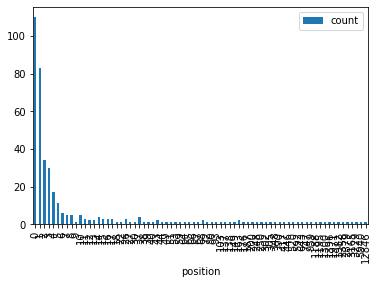

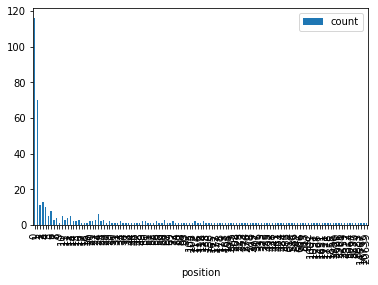

In [179]:
result_dict = copy.deepcopy(final_antonym_dict)

for temp_num in range(2):
    count_dict = {}
  
        
        
    for (key,value) in final_antonym_dict.items():
    
        # 没有预测结果的标记
        no_predict = 0

          # 处理模板
        print("==========================================================")
        text = templates[temp_num].replace('*',key)
        print(text)
    
    
        # module
        if mask_token is not None:
            text = text.replace(' _ ', ' %s ' % mask_token)
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
        tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
        marker = '*'
        if marker in tokens:
            assert tokens.count(marker) == 2, str(tokens)
            p, h = [i for i, token in enumerate(tokens) if token == marker]
            tokens = [token for token in tokens if token != marker]
            h -= 1
            print(tokens[p], tokens[h])
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
        tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
                  for token in tokens] 
        #print(tokens)

        input_ids = torch.tensor([token_ids])
        with torch.no_grad():
            logits, attns = model(input_ids, output_attentions=True)
            probs = F.softmax(logits, dim=-1)

        for i in pred_idx:
            top_probs, top_indexes = probs[0][i].topk(10)
            top_tokens = tokenizer.convert_ids_to_tokens(top_indexes) 


            # remove G
            ans = []
            for word in top_tokens:
                ans.append(word[1:])
            print(ans)
            print(top_probs)


            # 找到每个同义词位于预测的第几个位置，先找到概率最大的，再去找最大的是预测的第几个
            # 找到每个同义词对应的概率
            word_probe = {}
            for word in value:
                word_id = tokenizer._convert_token_to_id('Ġ'+ word)
                if (word_id != 3):
                    word_probe[word] = probs[0][i][word_id]
                else:
                    print(word + 'is not in list')

            print(word_probe)

            # 找到同义词中概率最大的词和值

            # 没有反义词在预测的结果里
            # 保存计算结果的json文件中写为 -1
            if (len(word_probe)==0):
                no_predict = 1
                break


            max_word = max(word_probe, key=word_probe.get)
            max_probe = word_probe[max_word]

            print('max_probe is: ',end='')
            print(max_probe)

            # 判断概率最大的同义词是预测的第几个
            # 不要陷入死循环
            # k的值不要超过 tensor 的长度
            k = 10
            probe_get = 0
            while(probe_get == 0):
                top_probs, top_indexes = probs[0][i].topk(k)
                #print(top_probs)
                if max_probe in top_probs:
                    print('the position of max probe is: ',end='')
                    print((top_probs == max_probe).nonzero().item())
                    print('-----------------------------------------------------')

                    probe_get = 1
                else:
                    k=k*2
                    print(k)
                    if (k >= list(probs[0][i].size())[0]):
                        top_probs, top_indexes = probs[0][i].topk(probs[0][i].size())
                        print(top_probs)
                        print('the position of max probe is: ',end='')
                        print((top_probs == max_probe).nonzero().item())
                        print('-----------------------------------------------------')
                        probe_get = 1


            print('*****************************************************')

            
        # 没有预测结果
        if(no_predict == 1):
            # 写入结果文件
            if (temp_num == 0):
                result_dict[key] = [result_dict[key],-1]
            else:
                result_dict[key].append(-1)
            continue

            
        # 有预测结果
        position = (top_probs == max_probe).nonzero().item()
        # 写入结果文件
        if (temp_num == 0):
            result_dict[key] = [result_dict[key],position]
        else:
            result_dict[key].append(position)


        if position not in count_dict:
            count_dict[position] = 1
        else:
            count_dict[position]+=1

       
    
    
    # 画图
    count_dict_keys = count_dict.keys()
    count_dict_values = count_dict.values()

    data = {
        'count':Series(count_dict_values),
        'position':Series(count_dict_keys)
    }

    df = DataFrame(data)
    df.sort_values("position",inplace=True)
    print(df)
    # plt.bar(count_dict_keys,count_dict_values)
    df.plot(x='position',y='count',kind='bar')
    
    
    
# 保存到json文件
with open("result_antonym.json", "w") as outfile:  
    json.dump(result_dict, outfile)
            


In [180]:
# 分析结束，结果文件: antonym_result.json